# Xray Images PCA

In [45]:
import pandas as pd
from PIL import Image
import numpy as np
import cv2
import math
from sklearn import svm
from array import array
import matplotlib.pyplot as plt
import numpy.linalg as LA
from itertools import permutations
from sklearn import neighbors,metrics
from matplotlib import pylab
#import matplotlib as plt

In [2]:
#function to load images into dataframe
def loaddata(rootdir):
    import os
    imagelist = []
    for (dirpath,dirnames,filenames) in os.walk(rootdir,followlinks=True):
        for file in filenames:
            if '.jpeg' in file:
                datalabel = dirpath.split('\\')[-2]
                classlabel =[0 if dirpath.split('\\')[-1]=='NORMAL' else 1][0]
                imagelist.append((dirpath+'\\'+ file,datalabel,classlabel))
    return pd.DataFrame(imagelist,columns=['image','data','class'])

In [3]:
#regenerate images
def regenerateImages(image):
    ResizeValNew= image.reshape(32, 32)
    #ResizeValNew.shape#(71,90)
    ImageReconstructedNew = Image.fromarray(ResizeValNew)
    ImageReconstructedNew.show()

In [4]:
def flatImages(dataset,selectedLabels):
    vals =[]
    for i in range(len(dataset.values)):
        #print (i)
        imgpath = dataset.iloc[i].image
        img = Image.open(imgpath).convert('L')
        img = img.resize((32,32), Image.ANTIALIAS)
        val = list(img.convert('L').getdata())
        vals.extend(val)
    datasetlabels = dataset.loc[:,dataset.columns == 'class']
    trainData= np.array(vals)
    trainlabel= np.array(datasetlabels)
    idx = [k for k in range(len(trainlabel)) if trainlabel[k] in selectedLabels]
    N = len(idx)
    X = np.zeros((N, 32 * 32), dtype=np.uint8)
    T = np.zeros((N, 1), dtype=np.uint8)
    for i in range(N):
        X[i] = trainData[idx[i] * 32 * 32:(idx[i] + 1) * 32 * 32]
        T[i] = trainlabel[idx[i]]
    return X,T

In [5]:
def Build2DHistograms(P, T, B, mn, mx):
    labels = np.unique(T)
    Hn = np.zeros([B,B]).astype('int32')
    Hp = np.zeros([B,B]).astype('int32')
    RC = np.clip(np.around(((B-1)*(P - mn)/(mx - mn)))  .astype('int32'), 0, B-1)
    for i, rc in enumerate(RC):
            if T[i] == labels[0]:
                Hn[rc[0], rc[1]] += 1
            else:
                Hp[rc[0], rc[1]] += 1
    return Hn, Hp

In [6]:
def Histogram2DClassifier (queries, mn, mx, Hn, Hp, labeln,labelp):
    B = np.alen(Hn)
    RC = np.clip(np.around(((B - 1) * (queries - mn) / (mx - mn))).astype('int32'), 0, B - 1)
    countn = Hn[RC[:, 0], RC[:, 1]]
    countp = Hp[RC[:, 0], RC[:, 1]] 
    resultlabel = np.full(np.alen(countn), 999, dtype=int)
    indicesn = countn > countp
    indicesp = countp > countn
    resultlabel[indicesn] = labeln
    resultlabel[indicesp] = labelp
    resultprob = countn/(countn+countp)
    resultprob[indicesp] = 1 - resultprob[indicesp]
    return resultlabel, resultprob

In [7]:
def Bayesian2DClassifier(queries, Nn, Np, mun, mup, cn, cp, labeln, labelp):
    w1 = 1
    w2 = 1
    A = w1*w2
    N = np.alen(queries)
    [countn, countp] = np.zeros((2, N))
    factorn = Nn * A * (1 / (2 * np.pi * np.sqrt(np.linalg.det(cn))))
    factorp = Np * A * (1 / (2 * np.pi * np.sqrt(np.linalg.det(cp))))
    icn = np.linalg.inv(cn)
    icp = np.linalg.inv(cp)
    for i, q in enumerate(queries):
        countn[i] = factorn*np.exp(-0.5 * np.dot(np.dot(q - mun, icn), q - mun))
        countp[i] = factorp*np.exp(-0.5 * np.dot(np.dot(q - mup, icp), q - mup))
    resultlabel = np.full(N, 999, dtype = int)
    indicesn = countn > countp
    indicesp = countp > countn
    resultlabel[indicesn] = labeln
    resultlabel[indicesp] = labelp
    resultprob = countn/(countn+countp)
    resultprob[indicesp] = 1 - resultprob[indicesp]
    return resultlabel, resultprob

In [8]:
def accuracy (truth, result):
    return (list((truth==result)).count(True))/np.alen(truth)

## Main

In [17]:
filedb = loaddata('G:/UCSC/machine learning/Final Project PCA/chest-xray-pneumonia/chest_xray/chest_xray')
train = filedb.loc[filedb['data']=='train']
trainlabels = train.loc[:,train.columns == 'class']
test = filedb.loc[filedb['data']=='test']
testImages = test.loc[:,test.columns == 'image']
testlabels = test.loc[:,test.columns == 'class']
filedb.shape


(5856, 3)

In [18]:
len(train.values)

5216

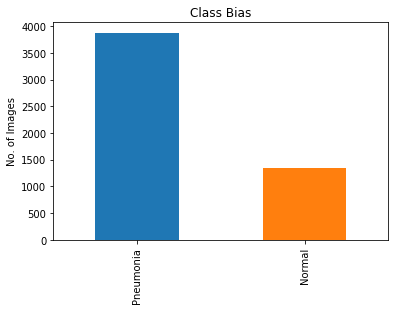

In [19]:
ClassCounts = train['class'].value_counts().plot(kind='bar')
ClassCounts.set_ylabel('No. of Images')
ClassCounts.set_title('Class Bias')
ClassCounts.set_xticklabels( ('Pneumonia', 'Normal') )
plt.show()

### Do PCA

In [20]:
X_train,Y_train = flatImages(train,selectedLabels=[0,1])

In [21]:
X_train.shape
Y_train.shape

X1= X_train
T1= Y_train

In [22]:
X1[1].shape#only 1 element has 32*32 dimensions(rows and columns)

(1024,)

In [23]:
X1[2]

array([ 8, 46, 76, ..., 60,  0,  0], dtype=uint8)

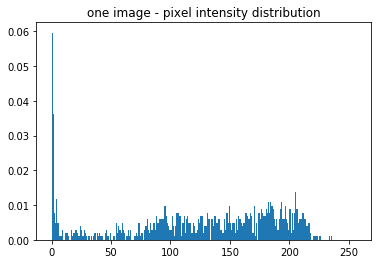

In [24]:
#Pixel intensity histogram
plt.hist(X1[2], bins=256, range=(0,256), normed=True)
plt.title('one image - pixel intensity distribution')
plt.show()

### Compute PCA

Text(0.5,1,'Original image')

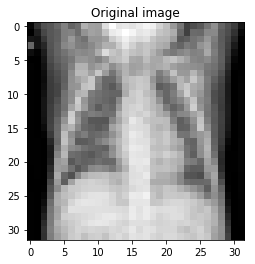

In [25]:
#Original Image
regenerateImages(X1[2])
plt.imshow(X1[2].reshape(32,32),interpolation = 'None', cmap = 'gray')
plt.title('Original image')


Text(0.5,1,'Mean image')

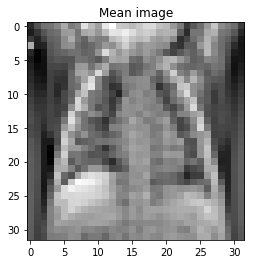

In [26]:
# XZCVPR process
mu = np.mean(X1, axis=0)
Z = X1 - mu;
plt.imshow(Z[2].reshape(32,32),interpolation = 'None', cmap = 'gray')
plt.title('Mean image')



Text(0.5,1,'Recovered image from eigen vector without mean')

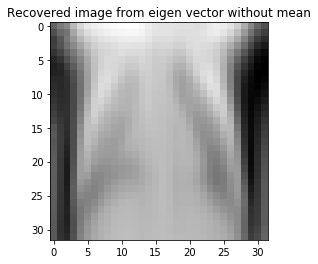

In [27]:
C = np.cov(Z, rowvar=False)
[Lambda, V] = LA.eigh(C)
Lambda=np.flipud(Lambda)
V=np.flipud(V.T)
V = V[:2]
P=np.dot(Z, V.T)
P.shape
R=np.dot(P,V)
#regenerateImages(R[2])
plt.imshow(R[2].reshape(32,32),interpolation = 'None', cmap = 'gray')
plt.title('Recovered image from eigen vector without mean')


In [63]:
P.shape
#P[:, 1]
#P[:, 0]

array([ 136.04007739, -693.57795902,  -94.40496616, ...,  195.13463826,
        723.34422027, -256.80658395])

Text(0.5,1,'Recovered image ')

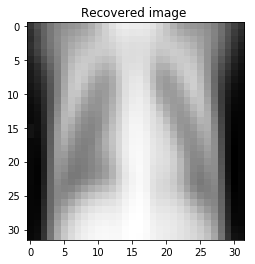

In [48]:
Xrec=R+mu
#regenerateImages(Xrec[2])#Not bad! may be the resolution needs to be tweaked
plt.imshow(Xrec[2].reshape(32,32),interpolation = 'None', cmap = 'gray')
plt.title('Recovered image ')

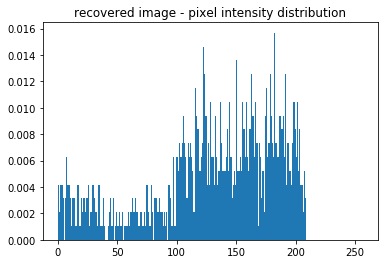

In [49]:
#Pixel intensity histogram
plt.hist(Xrec[2], bins=256, range=(0,256), normed=True)
plt.title('recovered image - pixel intensity distribution')
plt.show()

In [50]:
X_test,Y_test = flatImages(test,selectedLabels=[0,1])

In [51]:
# generate unique labels and counts in our labels dataset
T1 = T1.flatten()
[[labeln, labelp], [Nn, Np]] = np.unique(T1, return_counts=True);
labeln#unique values i.e. 0
labelp#unique valuesi.e. 1(Pneumonia)
Nn# 0 existed times =1341
Np# 1 existed times=3875(Pneumonia is clearly predominant)

3875

In [52]:
B = 32
mn = np.amin(P, axis=0)
mx = np.amax(P, axis=0)
p1min = mn[0]
p1max = mx[0]
p2min = mn[1]
p2max = mx[1]

mn#minimum value along each dimension i.e. 2 max values for 2 dimensions
mx#maximum value along each dimension i.e. 2 max values for 2 dimensions





array([3041.65379923, 1293.0536484 ])

In [53]:
[Hn, Hp] = Build2DHistograms(P, T1, B, mn, mx)

print("Shape of normal patients' Histogram is ",Hn.shape)
print("Normal patients' Histogram is ",Hn)
print("Shape of Pneumoniatic patients' Histogram is ",Hp.shape)
print("Pneumonia patients' Histogram is ",Hp)



Shape of normal patients' Histogram is  (32, 32)
Normal patients' Histogram is  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape of Pneumoniatic patients' Histogram is  (32, 32)
Pneumonia patients' Histogram is  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [54]:
#Write numpy array to excel file

In [55]:
df1 = pd.DataFrame (Hn)
df2 = pd.DataFrame (Hp)

## save to xlsx file

filepath1 = 'G:/UCSC/machine learning/Final Project PCA/HnFile.xlsx'
filepath2 = 'G:/UCSC/machine learning/Final Project PCA/HpFile.xlsx'

df1.to_excel(filepath1, index=False)
df2.to_excel(filepath2, index=False)

([array([32.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.]),
  array([32.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.]),
  array([32.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.]),
  array([31.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.]),
  array([26.,  4.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  

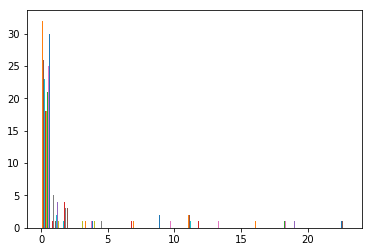

In [36]:
plt.hist(Hn, bins=32)

([array([31.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.]),
  array([30.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.]),
  array([27.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.]),
  array([28.,  1.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.]),
  array([23.,  0.,  3.,  1.,  2.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.]),
  array([20.,  4.,  1.,  0.,  2.,  0.,  0.,  1.,  2.,  

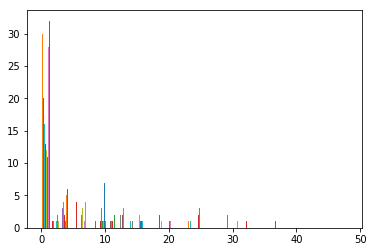

In [37]:
plt.hist(Hp, bins=32)

In [38]:
[Hlabels, Hprobs] = Histogram2DClassifier(P, mn, mx, Hn, Hp, labeln, labelp)
np.where(Hlabels==1)

(array([   0,    1,    2, ..., 5213, 5214, 5215], dtype=int64),)

In [72]:
accuracyH = accuracy(T1, Hlabels)*100
accuracyH
#P.shape

74.29064417177914

In [40]:
#Bayesian classifier
#P#2 dimensions for all the observations
mun = np.mean(P[T1==labeln], axis=0)
mun
mup = np.mean(P[T1==labelp], axis=0)
mup
cn = np.cov(P[T1==labeln], rowvar=False)
cn
cp = np.cov(P[T1==labelp], rowvar=False)
cp

[Blabels, Bprobs] = Bayesian2DClassifier(P, Nn, Np, mun, mup, cn, cp, labeln, labelp)
[Blabels, Bprobs]
Blabels


array([1, 1, 1, ..., 1, 1, 1])

In [41]:
accuracyB = accuracy(T1, Blabels)*100
accuracyB

74.29064417177914

### Plot Confusion Matrix

In [56]:
cols = np.zeros((np.alen(T1), 4))
cols.shape


(5216, 4)

In [60]:
cols[T1==labeln] = [1, 0, 0, 0.25]
cols[T1==labelp] = [0, 1, 0, 0.25]
#randomorder = permutations(np.arange(np.alen(T)))
cols[T1==labeln].shape
cols[T1==labelp].shape


(3875, 4)

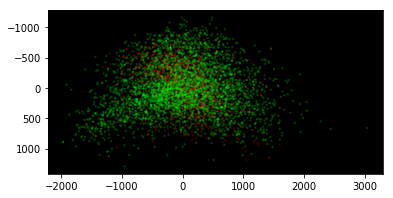

In [64]:
fig = pylab.figure()
ax = fig.add_subplot(111, facecolor = "black")
#ax.scatter(P[randomorder, 1], P[randomorder, 0], s=5, linewidths=0, facecolors=cols[randomorder, :], marker= "o")
ax.scatter( P[:, 0],P[:, 1], s=5, linewidths=0, facecolors=cols[:, :], marker= "o")
ax.set_aspect('equal')
pylab.gca().invert_yaxis()

In [65]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, Y_train)
GaussianNB(priors=None)



F:\Anaconda\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None)

In [66]:
Gaussian_pred = clf.predict(X_test)
print(Gaussian_pred)

[1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0
 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1
 1 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 

#### Plot Confusion Matrix

In [67]:
import itertools

In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[142  92]
 [ 87 303]]


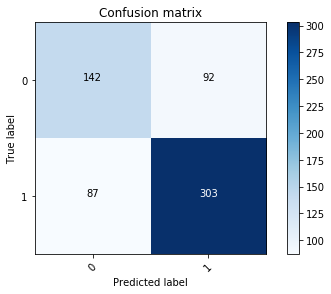

In [70]:
gm = metrics.confusion_matrix(Y_test, Gaussian_pred)
plot_confusion_matrix(gm,["0","1"])

In [ ]:
#72% accuracy on testing dataset

#precision=Precision-77%
#Recall-78%
#F1 measure -77%